In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm import tqdm

from src import data, paths, matrix_filtering, communicatin_metrics, plotting
from scipy import signal

from sklearn import metrics as sk_metrics
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('ggplot')
%matplotlib inline

!date -I

2024-05-12


## Settings

In [2]:
EMPIRICAL_SIMULATED = 'empirical' # 'simulated'
RESPONSE_LENGTH = 200
GRAPH_DENSITY = 0.25

fig_dir = f"pytepfit_results/{EMPIRICAL_SIMULATED}/{RESPONSE_LENGTH}/"
%mkdir -p  {paths.path_figures(fig_dir)}
results_dir = f'interim/pyTepFit_{EMPIRICAL_SIMULATED}/'
%mkdir -p {paths.path(results_dir)}

In [3]:
def plot_data(data,title=None,stimulation_time=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data)
    if stimulation_time:
        plt.axvline(stimulation_time, ymin=np.min(data), ymax=np.max(data),ls=":",label="stimulation time")
    plt.title(title)
    

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*data.shape[0],color="k")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="k")
    plt.title(labels[roi_id])
    plt.show()

## Load data

### Load pytepfit data

In [4]:
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(paths.path(f'{pytepfit_path}source_estimates/{EMPIRICAL_SIMULATED}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [5]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [6]:
stimulation_time = 100

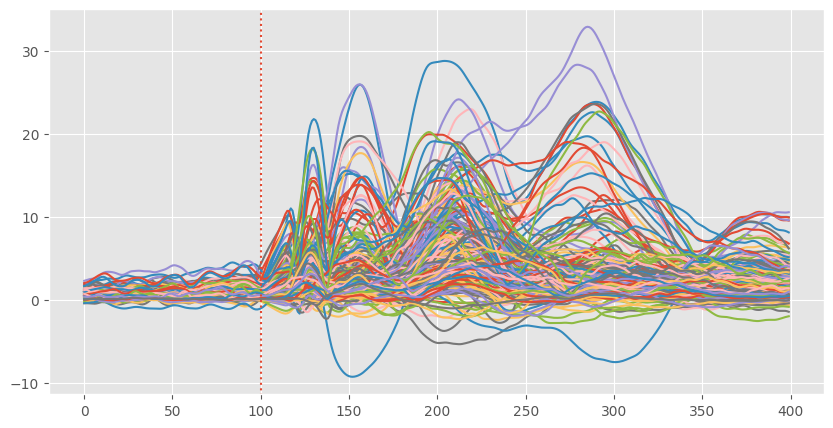

In [7]:
data_ts = data_pytepfit['ts']
plot_data(data_ts,stimulation_time=stimulation_time)

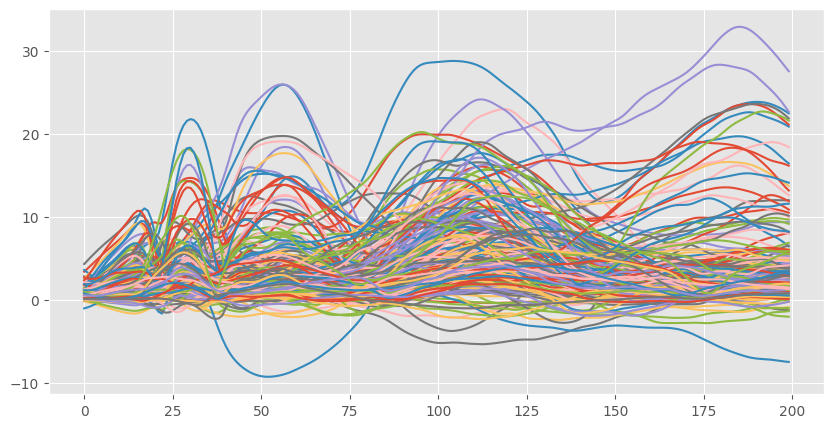

In [8]:
data_ts_croped = data_ts[stimulation_time:stimulation_time+RESPONSE_LENGTH,:]
plot_data(data_ts_croped)
plt.savefig(paths.path_figures(fig_dir+"cropped_data.pdf"))
plt.show()

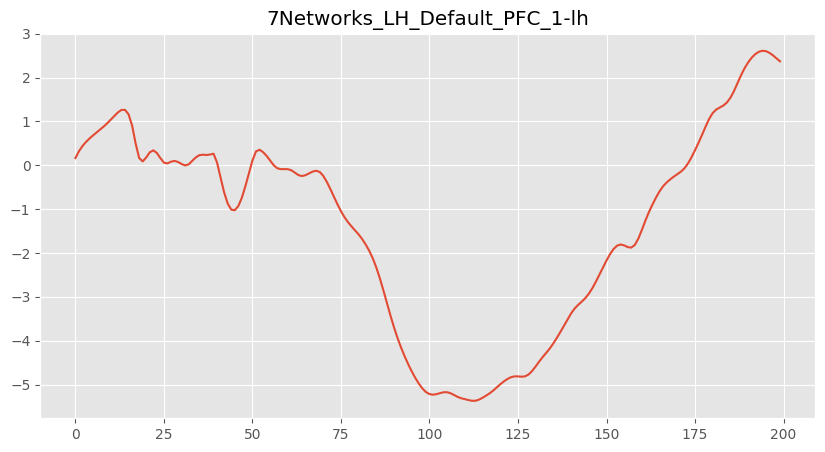

In [9]:
plot_one_roi(data_ts_croped,17,data_pytepfit['labels'])

In [10]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)
    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(data,stim_idx):
    maxima = np.max(data[stim_idx:,:],axis=0)
    print(maxima.shape)
    maxima.sort()

    upper = int(maxima[-30]) # for higest threshold there should be at least 30 responses above for statistics
    lower = int(np.max(data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    if step <1:
        step = 1

    return range(lower, upper, step)

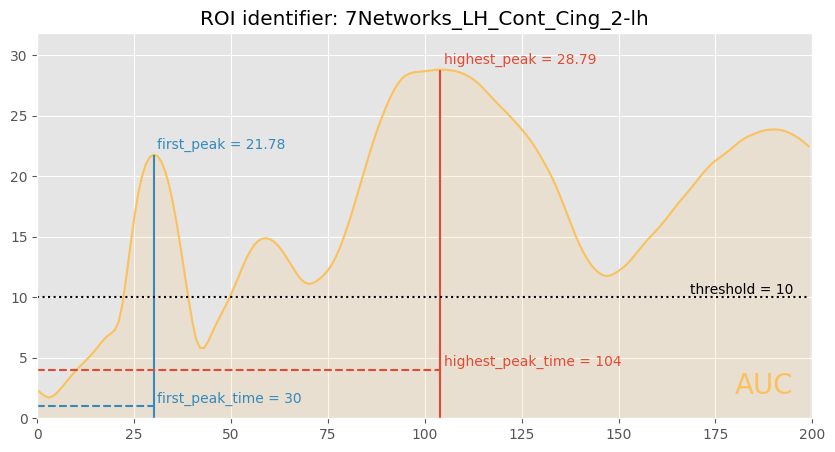

In [11]:
colors=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']

def plot_one_roi_response_definitions(data,roi_id,labels,thr):
    plt.rcParams['figure.figsize'] = [10, 5]
    selected_curve = data[:,roi_id]

    amp_id, amp, amp_h_id, amp_h = peak_analysis(selected_curve,threshold=thr)

    auc_color = colors[4]
    first_peak_color = colors[1]
    highest_peak_color = colors[0]

    plt.figure()

    plt.plot(data[:,roi_id],color=auc_color)
    plt.fill_between([i for i in range(len(selected_curve))],selected_curve,alpha=0.15,color=auc_color)
    plt.text(RESPONSE_LENGTH-20, 2, "AUC",color=auc_color,fontsize=20)

    plt.vlines(amp_id, 0, amp,color=first_peak_color)
    plt.text(amp_id+1, amp+0.5, f"first_peak = {amp:.2f}",color=first_peak_color)
    plt.plot([1]*(amp_id+1),color=first_peak_color,ls="--")
    plt.text(amp_id+1, 1+0.3, f"first_peak_time = {amp_id}",color=first_peak_color)

    plt.vlines(amp_h_id, 0, amp_h,color=highest_peak_color)
    plt.text(amp_h_id+1, amp_h+0.5, f"highest_peak = {amp_h:.2f}",color=highest_peak_color)
    plt.plot([4]*(amp_h_id+1),color=highest_peak_color,ls="--")
    plt.text(amp_h_id+1, 4+0.3, f"highest_peak_time = {amp_h_id}",color=highest_peak_color)

    ax = plt.gca()
    ax.set_ylim([0,amp_h+3])
    ax.set_xlim([0, len(selected_curve)])

    
    plt.title(f"ROI identifier: {labels[roi_id]}")
    plt.plot([thr]*len(selected_curve),color="k",ls=":")
    plt.text(len(selected_curve)-5, thr+0.3, f"threshold = {thr}",color='k',horizontalalignment='right')
    
    path = paths.path_figures(fig_dir+labels[roi_id]+"_response_def.pdf")
    plt.savefig(path)
    plt.show()

if RESPONSE_LENGTH > 100:
    plot_one_roi_response_definitions(data_ts_croped,1,labels=data_pytepfit['labels'],thr=10)

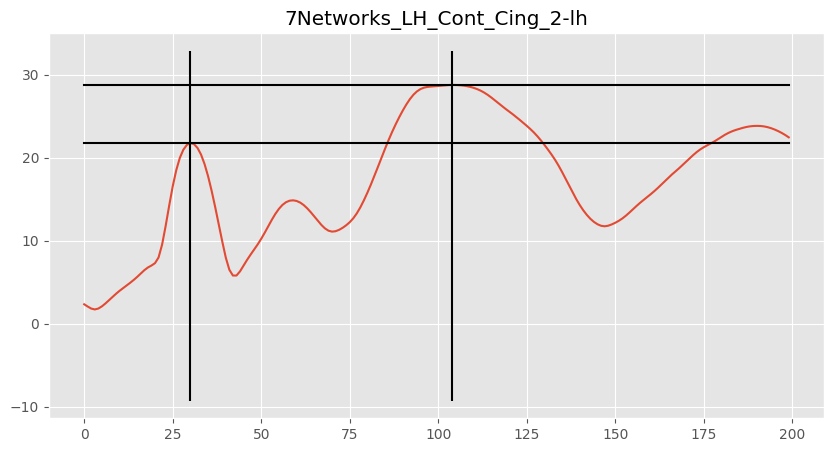

In [12]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts_croped[:,roi_idx],threshold=8)


plot_one_roi(data_ts_croped,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [13]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)
list_of_thresholds = []

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.where(np.max(data_ts_croped,axis=0) > threshold,1,0)

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts_croped[:,i],threshold)

    response_df['first_peak'] = peak_analysis_results[:,0]
    response_df['first_peak_time'] = peak_analysis_results[:,1]
    response_df['highest_peak'] = peak_analysis_results[:,2]
    response_df['highest_peak_time'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts_croped,axis=0)
    response_df['diff'] = np.max(data_ts_croped,axis=0)-np.min(data_ts_croped,axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), (data_ts_croped[:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts_croped[:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],np.nan)

    responses[threshold] = response_df
    list_of_thresholds.append(threshold)

(200,)


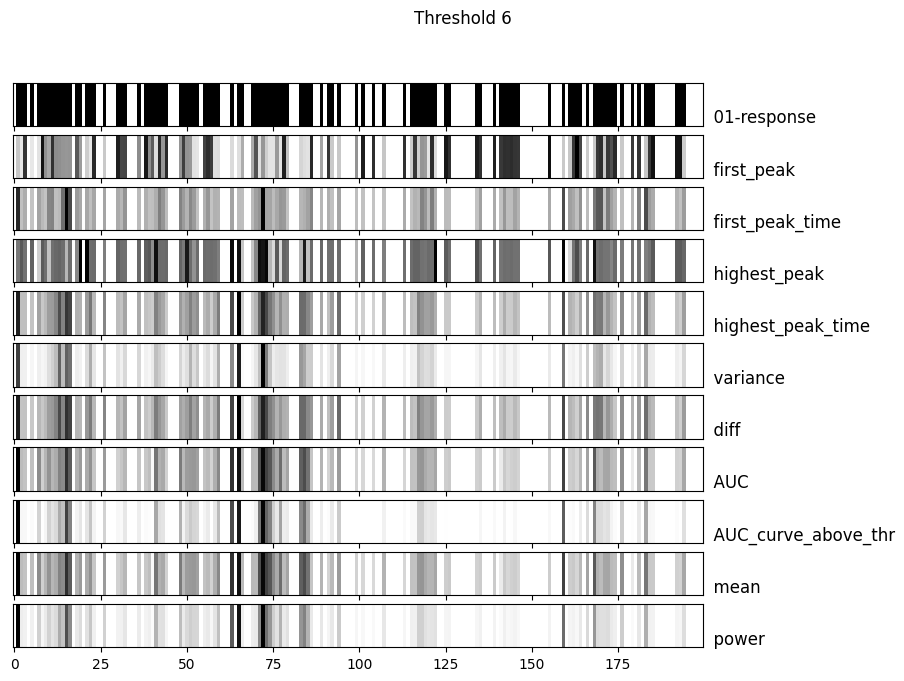

In [14]:
thr = list_of_thresholds[2]

fig, axs = plotting.prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")


for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

In [15]:
stim_locatin = 85 # we know this from previous notebooks

### Load structural connectivity data

In [16]:
SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit()

SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,GRAPH_DENSITY)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

/home/katterrina/fi_muni/0_diplomka/src/data.py:134: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("PyTepFit_simple",SC_W_pytep, SC_L_pytep,np.log(SC_W_pytep)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [17]:
centroids_file = paths.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)

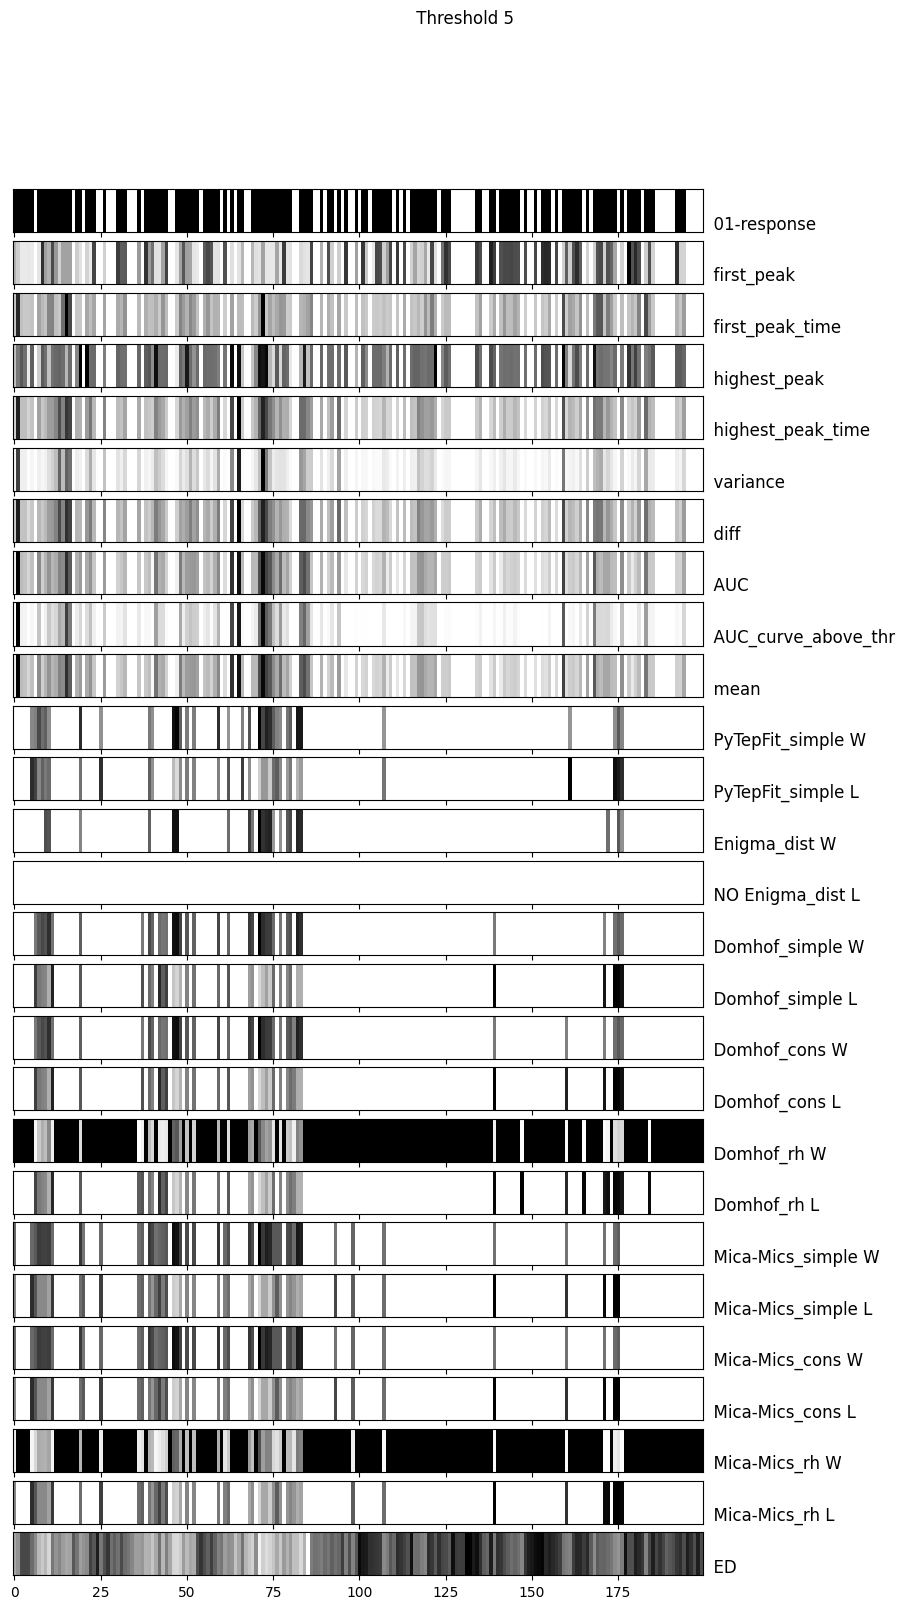

In [18]:
thr = list_of_thresholds[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = plotting.prepare_barcode(n_of_response_def+2*len(SC_matrices),200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

for j,d in enumerate(SC_matrices):
    name, SC_W,SC_L,SC_W_log = d
    plotting.plot_one_barcode(axs[i+2*j],SC_W_log[stim_locatin],title=f"{name} W")
    if SC_L is not None:
        plotting.plot_one_barcode(axs[i+2*j+1],SC_L[stim_locatin],title=f"{name} L")
    else:
        z = np.zeros(SC_W_log[stim_locatin].shape)
        plotting.plot_one_barcode(axs[i+2*j+1],z,title=f"NO {name} L")

plotting.plot_one_barcode(axs[-1],ED[stim_locatin],title=f"ED")
plt.savefig(paths.path_figures(fig_dir+"barcode.pdf"))

In [19]:
all_responses = pd.concat(responses)
all_responses

01-response  first_peak  first_peak_time  highest_peak  \
4  0              1        47.0         5.816432          47.0   
   1              1        30.0        21.778551         104.0   
   2              1        13.0         6.474365         128.0   
   3              1        13.0         5.517997         109.0   
   4              1        15.0         5.643366          15.0   
...             ...         ...              ...           ...   
13 195            0         NaN              NaN           NaN   
   196            0         NaN              NaN           NaN   
   197            0         NaN              NaN           NaN   
   198            0         NaN              NaN           NaN   
   199            0         NaN              NaN           NaN   

        highest_peak_time   variance       diff          AUC  \
4  0             5.816432   3.123393   6.224032   253.332072   
   1            28.793386  55.774696  27.077971  3429.233902   
   2             8.258207   4.778983   7.251653   899.571678   
   3             8.355309   4.468710   7.336567   795.702728   
   4             5.643366   0.600524   4.283547   560.813191   
...                   ...        ...        ...          ...   
13 195                NaN        NaN        NaN          NaN   
   196                NaN        NaN        NaN          NaN   
   197                NaN        NaN        NaN          NaN   
   198                NaN        NaN        NaN          NaN   
   199                NaN        NaN        NaN          NaN   

        AUC_curve_above_thr       mean         power  
4  0              18.783715   1.280818    952.777344  
   1            2648.501212  17.208191  70379.312500  
   2             241.025893   4.514212   5031.417969  
   3             169.231327   3.990539   4078.622070  
   4              10.066674   2.813737   1703.527832  
...                     ...        ...           ...  
13 195                  NaN        NaN           NaN  
   196                  NaN        NaN           NaN  
   197                  NaN        NaN           NaN  
   198                  NaN        NaN           NaN  
   199                  NaN        NaN           NaN  

[2000 rows x 11 columns]

## One selected SC matrix

Select Mica-Mics structural with RH preprocessing, because we already know that it results into correlations for F-Tract.

In [20]:
for i, m in enumerate(SC_matrices):
    print(i, m[0])

0 PyTepFit_simple
1 Enigma_dist
2 Domhof_simple
3 Domhof_cons
4 Domhof_rh
5 Mica-Mics_simple
6 Mica-Mics_cons
7 Mica-Mics_rh


In [21]:
name, SC_W, SC_L, SC_W_log = SC_matrices[7]

## Correlations

In [22]:
def select_response_by_definition(definition,rdict):
    new_df = pd.DataFrame()
    for thr in rdict.keys():
        new_df[f"{thr:02d}"] = rdict[thr][definition]
    
    return new_df  

In [23]:
def plot_df_as_heatmap(df,x_axis,y_axis,value,x_label="threshold",y_label="",p=None,title=None,ax=None):
    plt.figure(figsize=(8,8))
    pivot = df.pivot_table(index=x_axis, columns=y_axis, values=value,sort=False)
    if p is not None:
        pivot_p = df.pivot_table(index=x_axis, columns=y_axis, values=p,sort=False)
        pivot = pivot.where(pivot_p < 0.05)

    cmap = LinearSegmentedColormap.from_list('', ['#FF2200', 'white', '#FF2200'])# 'seismic'

    if ax is not None:
        sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    else:
        ax = sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    ax.set_title(title)
    ax.set(xlabel=x_label)
    ax.set(ylabel=y_label)
    plt.yticks(rotation=0) 
    plt.savefig(paths.path_figures(fig_dir+title+".pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()

def corr_columns_of_two_matrices(responses_by_threshold,metrics):

    col_names_thresholds = list(responses_by_threshold.keys())
    col_names_SC = list(metrics.keys())

    df = pd.concat([responses_by_threshold,metrics], axis=1, join="inner")

    stat_pg = pg.pairwise_corr(df,columns=[col_names_thresholds,col_names_SC],method="spearman").round(3)

    return stat_pg

In [24]:
com_metrics_matrices = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

dict_metrics = {}
for c in com_metrics_matrices:
    dict_metrics[c] = com_metrics_matrices[c][stim_locatin]

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:23: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE"] = np.divide(1,shortest_paths)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:26: RuntimeWarning: divide by zero encountered in divide
  shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:27: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE_W"] = np.divide(1,shortest_paths)


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:47: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["NAV"] = np.divide(1,nav_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:781: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
0,45.307805,0.001481,56.91748,0.017569,0.009146,0.005899,8.492163,8.492163,0.017569,0.004902
1,56.289608,0.000000,inf,0.012035,0.007808,0.001445,inf,13.765920,0.008938,0.003926
2,92.766248,0.000000,inf,0.008308,0.006559,0.000284,inf,13.524316,0.006877,0.002492
3,94.172221,0.000000,inf,0.008227,0.007810,0.001046,inf,15.620317,0.008135,0.004036
4,92.564602,0.000000,inf,0.008065,0.007312,0.000696,inf,12.555779,0.008065,0.003484
...,...,...,...,...,...,...,...,...,...,...
195,115.547602,0.000000,inf,0.006240,0.004349,0.000006,inf,24.493235,0.004887,0.003644
196,105.548873,0.000000,inf,0.006381,0.004389,0.000011,inf,22.163802,0.003238,0.003574
197,90.633878,0.000000,inf,0.009385,0.005021,0.000052,inf,15.122497,0.009385,0.002838
198,114.749213,0.000000,inf,0.006213,0.004343,0.000007,inf,23.728181,0.004536,0.003356


0it [00:00, ?it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,200,-0.183,"[-0.31, -0.05]",0.009,0.741
1,04,SC_W,spearman,two-sided,200,0.140,"[0.0, 0.27]",0.047,0.511
2,04,SC_L,spearman,two-sided,200,-0.150,"[-0.28, -0.01]",0.035,0.564
3,04,SPE,spearman,two-sided,200,0.165,"[0.03, 0.3]",0.019,0.651
4,04,SPE_W,spearman,two-sided,200,0.145,"[0.01, 0.28]",0.040,0.538
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,200,0.189,"[0.05, 0.32]",0.007,0.767
96,13,SI,spearman,two-sided,199,-0.138,"[-0.27, 0.0]",0.052,0.494
97,13,SI_L,spearman,two-sided,199,-0.233,"[-0.36, -0.1]",0.001,0.916
98,13,NAV,spearman,two-sided,200,0.301,"[0.17, 0.42]",0.000,0.992


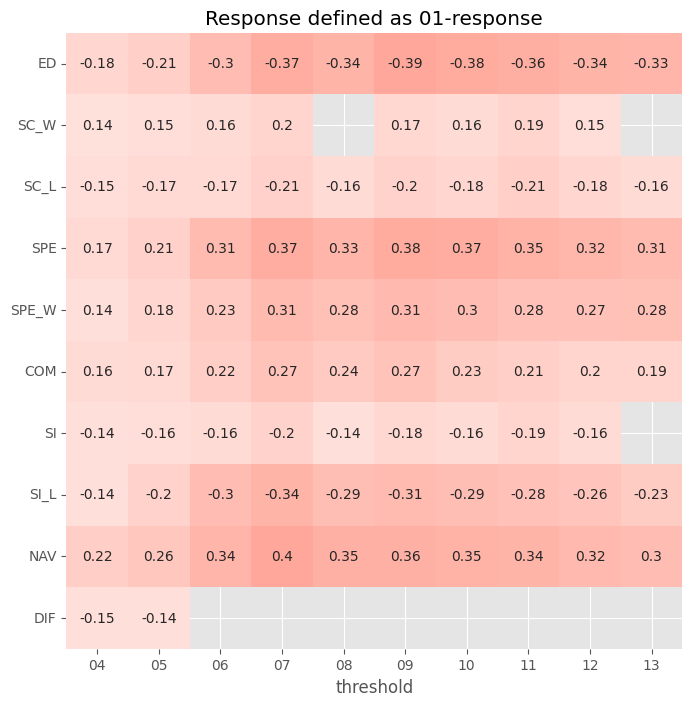

1it [00:01,  1.11s/it]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.286,"[0.14, 0.42]",0.000,0.955
1,04,SC_W,spearman,two-sided,157,-0.214,"[-0.36, -0.06]",0.007,0.773
2,04,SC_L,spearman,two-sided,157,0.233,"[0.08, 0.38]",0.003,0.841
3,04,SPE,spearman,two-sided,157,-0.307,"[-0.44, -0.16]",0.000,0.977
4,04,SPE_W,spearman,two-sided,157,-0.335,"[-0.47, -0.19]",0.000,0.991
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,-0.350,"[-0.61, -0.03]",0.034,0.578
96,13,SI,spearman,two-sided,36,0.170,"[-0.17, 0.47]",0.322,0.169
97,13,SI_L,spearman,two-sided,36,0.304,"[-0.03, 0.57]",0.072,0.445
98,13,NAV,spearman,two-sided,37,-0.340,"[-0.6, -0.02]",0.040,0.550


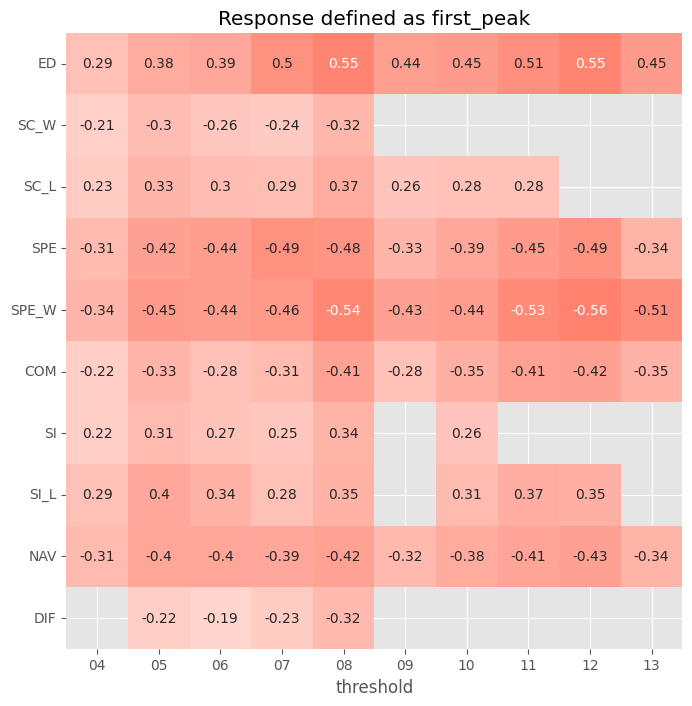

2it [00:02,  1.06s/it]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.283,"[-0.42, -0.13]",0.000,0.952
1,04,SC_W,spearman,two-sided,157,0.158,"[0.0, 0.31]",0.049,0.507
2,04,SC_L,spearman,two-sided,157,-0.182,"[-0.33, -0.03]",0.022,0.631
3,04,SPE,spearman,two-sided,157,0.291,"[0.14, 0.43]",0.000,0.962
4,04,SPE_W,spearman,two-sided,157,0.270,"[0.12, 0.41]",0.001,0.931
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,-0.043,"[-0.36, 0.28]",0.800,0.057
96,13,SI,spearman,two-sided,36,0.066,"[-0.27, 0.39]",0.700,0.067
97,13,SI_L,spearman,two-sided,36,0.021,"[-0.31, 0.35]",0.905,0.051
98,13,NAV,spearman,two-sided,37,0.037,"[-0.29, 0.36]",0.827,0.055


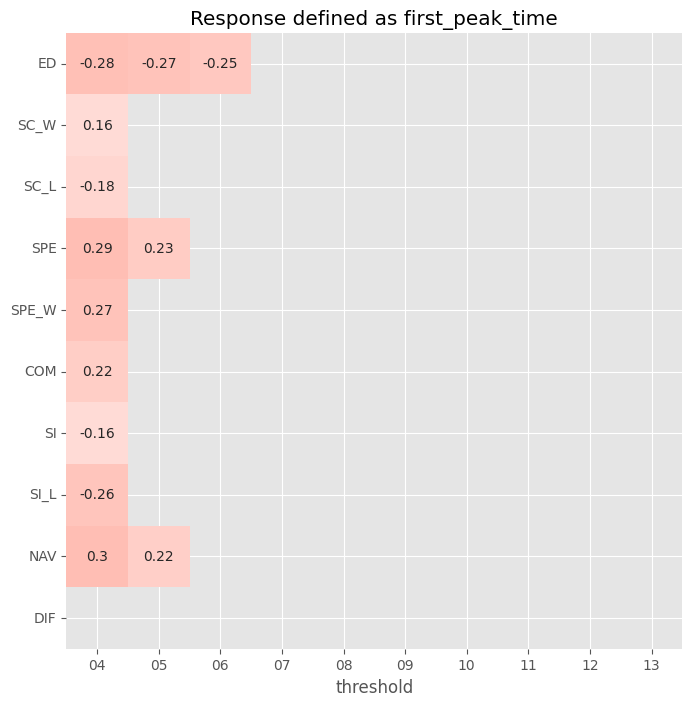

3it [00:02,  1.05it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,0.121,"[-0.04, 0.27]",0.131,0.329
1,04,SC_W,spearman,two-sided,157,-0.106,"[-0.26, 0.05]",0.187,0.263
2,04,SC_L,spearman,two-sided,157,0.156,"[-0.0, 0.3]",0.052,0.497
3,04,SPE,spearman,two-sided,157,-0.147,"[-0.3, 0.01]",0.066,0.455
4,04,SPE_W,spearman,two-sided,157,-0.154,"[-0.3, 0.0]",0.054,0.488
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,0.090,"[-0.24, 0.4]",0.595,0.083
96,13,SI,spearman,two-sided,36,0.089,"[-0.25, 0.41]",0.604,0.081
97,13,SI_L,spearman,two-sided,36,0.041,"[-0.29, 0.36]",0.812,0.056
98,13,NAV,spearman,two-sided,37,-0.053,"[-0.37, 0.28]",0.754,0.061


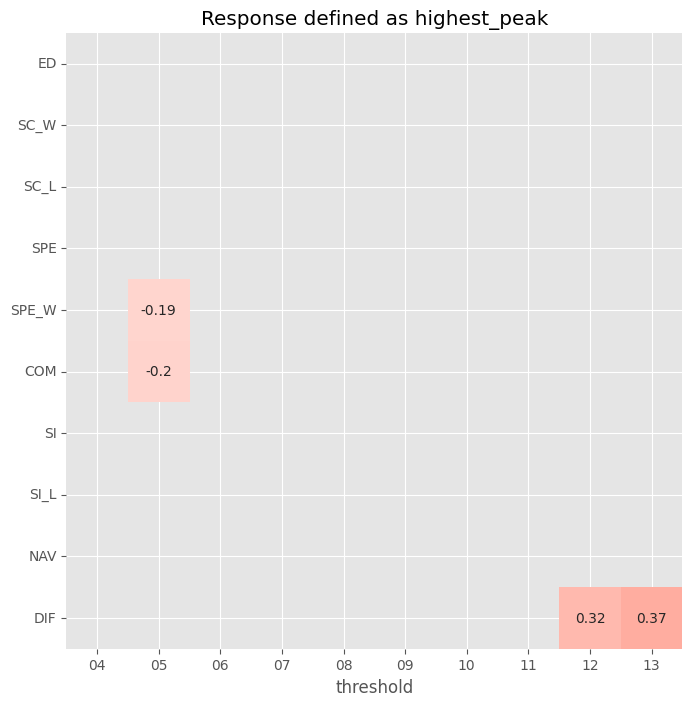

4it [00:03,  1.12it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,04,ED,spearman,two-sided,157,-0.456,"[-0.57, -0.32]",0.000,1.000
1,04,SC_W,spearman,two-sided,157,0.226,"[0.07, 0.37]",0.004,0.818
2,04,SC_L,spearman,two-sided,157,-0.242,"[-0.38, -0.09]",0.002,0.868
3,04,SPE,spearman,two-sided,157,0.440,"[0.3, 0.56]",0.000,1.000
4,04,SPE_W,spearman,two-sided,157,0.413,"[0.27, 0.53]",0.000,1.000
...,...,...,...,...,...,...,...,...,...
95,13,COM,spearman,two-sided,37,0.481,"[0.19, 0.7]",0.003,0.871
96,13,SI,spearman,two-sided,36,-0.248,"[-0.53, 0.09]",0.144,0.314
97,13,SI_L,spearman,two-sided,36,-0.438,"[-0.67, -0.13]",0.008,0.780
98,13,NAV,spearman,two-sided,37,0.522,"[0.24, 0.72]",0.001,0.928


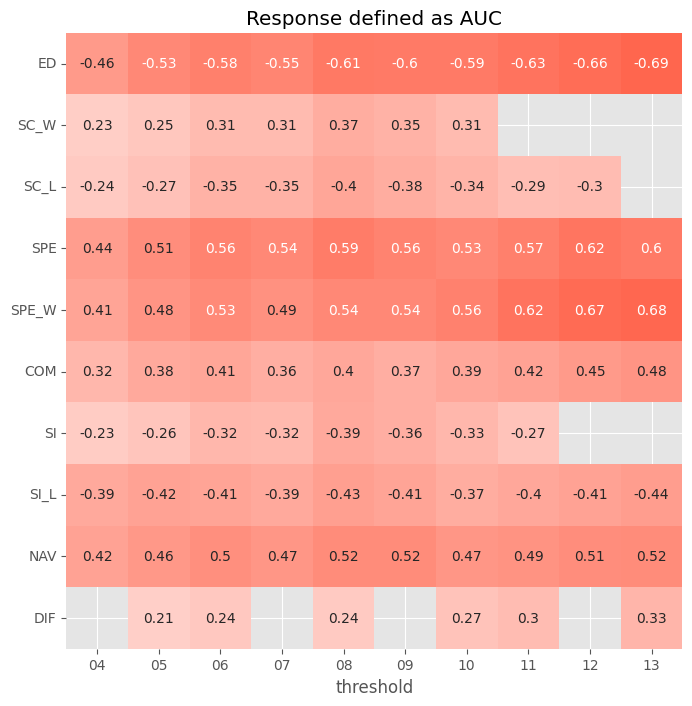

5it [00:04,  1.04it/s]


In [25]:
selected_response_definitions= ['01-response', 'first_peak', 'first_peak_time', 'highest_peak', 'AUC']
#pd.set_option('display.max_rows', None)

plt.style.use('ggplot')
for i,resp_definition in tqdm(enumerate(selected_response_definitions)):
    responses_df = select_response_by_definition(resp_definition,responses)  
    
    df = corr_columns_of_two_matrices(responses_df,df_metrics)
        
    display(df)
    
    plot_df_as_heatmap(df,"Y","X","r",p="p-unc",title=f"Response defined as {resp_definition}")


In [26]:
df_metrics['label'] = data_pytepfit['labels']

if EMPIRICAL_SIMULATED == 'empirical':
    df_metrics_AUC = df_metrics.copy()
    df_metrics_01 = df_metrics.copy()

    for thr in list(responses.keys()):
        df_metrics_AUC["response"] = responses[thr]["AUC"]
        df_metrics_01["response"] = responses[thr]["01-response"]

        df_metrics_AUC_id = df_metrics_AUC.set_index('label')
        df_metrics_01_id = df_metrics_01.set_index('label')

        df_metrics_AUC_id.to_csv(paths.path(f'{results_dir}response_AUC_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
        df_metrics_01_id.to_csv(paths.path(f'{results_dir}response_01_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))